# Assignment Module 2: Product Classification

The goal of this assignment is to implement a neural network that classifies smartphone pictures of products found in grocery stores. The assignment will be divided into two parts: first, you will be asked to implement from scratch your own neural network for image classification; then, you will fine-tune a pretrained network provided by PyTorch.


## Preliminaries: the dataset

The dataset you will be using contains natural images of products taken with a smartphone camera in different grocery stores:

<p align="center">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Granny-Smith.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Pink-Lady.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Lemon.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Banana.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Vine-Tomato.jpg" width="150">
</p>
<p align="center">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Yellow-Onion.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Green-Bell-Pepper.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Arla-Standard-Milk.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Oatly-Natural-Oatghurt.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Alpro-Fresh-Soy-Milk.jpg" width="150">
</p>

The products belong to the following 43 classes:
```
0.  Apple
1.  Avocado
2.  Banana
3.  Kiwi
4.  Lemon
5.  Lime
6.  Mango
7.  Melon
8.  Nectarine
9.  Orange
10. Papaya
11. Passion-Fruit
12. Peach
13. Pear
14. Pineapple
15. Plum
16. Pomegranate
17. Red-Grapefruit
18. Satsumas
19. Juice
20. Milk
21. Oatghurt
22. Oat-Milk
23. Sour-Cream
24. Sour-Milk
25. Soyghurt
26. Soy-Milk
27. Yoghurt
28. Asparagus
29. Aubergine
30. Cabbage
31. Carrots
32. Cucumber
33. Garlic
34. Ginger
35. Leek
36. Mushroom
37. Onion
38. Pepper
39. Potato
40. Red-Beet
41. Tomato
42. Zucchini
```

The dataset is split into training (`train`), validation (`val`), and test (`test`) set.

The following code cells download the dataset and define a `torch.utils.data.Dataset` class to access it. This `Dataset` class will be the starting point of your assignment: use it in your own code and build everything else around it.

In [ ]:
!git clone https://github.com/marcusklasson/GroceryStoreDataset.git

Cloning into 'GroceryStoreDataset'...
remote: Enumerating objects: 6559, done.
remote: Counting objects: 100% (266/266), done.
remote: Compressing objects: 100% (231/231), done.
remote: Total 6559 (delta 45), reused 35 (delta 35), pack-reused 6293 (from 1)
Receiving objects: 100% (6559/6559), 116.26 MiB | 19.38 MiB/s, done.
Resolving deltas: 100% (275/275), done.
Updating files: 100% (5717/5717), done.


In [ ]:
from pathlib import Path
from PIL import Image
from torch import Tensor
from torch.utils.data import Dataset, DataLoader
from typing import List, Tuple
import copy

import matplotlib.pyplot as plt
import cv2
from torchvision import transforms

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim # Import the optim module

from IPython.display import Markdown, display

def display_markdown(markdown_text: str):
    display(Markdown(markdown_text))

In [ ]:
class GroceryStoreDataset(Dataset):

    def __init__(self, split: str, transform=None) -> None:
        super().__init__()

        self.root = Path("GroceryStoreDataset/dataset")
        self.split = split
        self.paths, self.labels = self.read_file()

        self.transform = transform

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]:
        img = Image.open(self.root / self.paths[idx])
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

    def read_file(self) -> Tuple[List[str], List[int]]:
        paths = []
        labels = []

        with open(self.root / f"{self.split}.txt") as f:
            for line in f:
                # path, fine-grained class, coarse-grained class
                path, _, label = line.replace("\n", "").split(", ")
                paths.append(path), labels.append(int(label))

        return paths, labels

    def get_num_classes(self) -> int:
        return max(self.labels) + 1

## Part 1: design your own network

Your goal is to implement a convolutional neural network for image classification and train it on `GroceryStoreDataset`. You should consider yourselves satisfied once you obtain a classification accuracy on the **validation** split of **around 60%**. You are free to achieve that however you want, except for a few rules you must follow:

- You **cannot** simply instantiate an off-the-self PyTorch network. Instead, you must construct your network as a composition of existing PyTorch layers. In more concrete terms, you can use e.g. `torch.nn.Linear`, but you **cannot** use e.g. `torchvision.models.alexnet`.

- Justify every *design choice* you make. Design choices include network architecture, training hyperparameters, and, possibly, dataset preprocessing steps. You can either (i) start from the simplest convolutional network you can think of and add complexity one step at a time, while showing how each step gets you closer to the target ~60%, or (ii) start from a model that is already able to achieve the desired accuracy and show how, by removing some of its components, its performance drops (i.e. an *ablation study*). You can *show* your results/improvements however you want: training plots, console-printed values or tables, or whatever else your heart desires: the clearer, the better.

Don't be too concerned with your network performance: the ~60% is just to give you an idea of when to stop. Keep in mind that a thoroughly justified model with lower accuracy will be rewarded **more** points than a poorly experimentally validated model with higher accuracy.

## Part 1: Solution

The first thing we do is visualize the images in the dataset and printing the shape of the images to understand if there is the need to do some pre-processing of the data.

Image size: (348, 348, 3)
Package: Juice


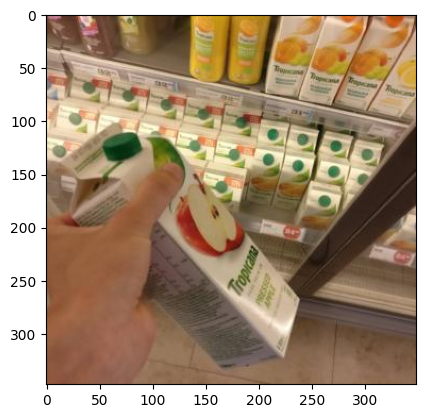

In [ ]:
img_path = '/content/GroceryStoreDataset/dataset/train/Packages/Juice/Tropicana-Apple-Juice/Tropicana-Apple-Juice_011.jpg'

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)

print("Image size:", img.shape)
print("Package: Juice")

Image size: (348, 348, 3)
Vegetable: Carrot


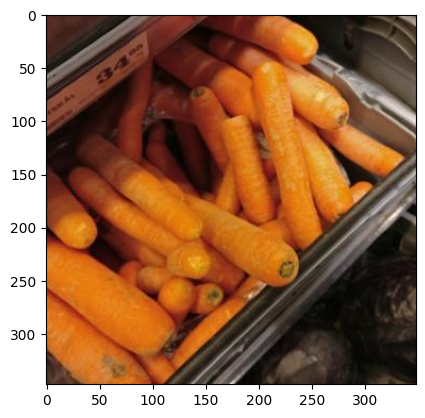

In [ ]:
img_path = '/content/GroceryStoreDataset/dataset/train/Vegetables/Carrots/Carrots_022.jpg'
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

print("Image size:", img.shape)
print("Vegetable: Carrot")

Image size: (348, 348, 3)
Fruit: Pineapple


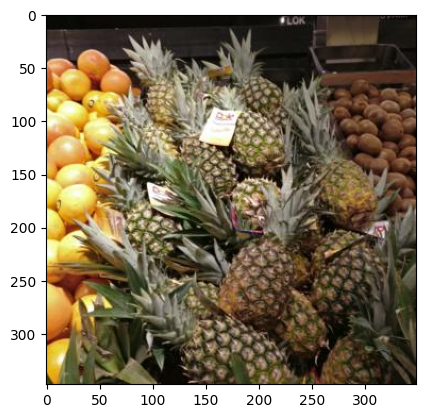

In [ ]:
img_path = '/content/GroceryStoreDataset/dataset/train/Fruit/Pineapple/Pineapple_007.jpg'
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

print("Image size:", img.shape)
print("Fruit: Pineapple")

In [ ]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

We resize the images of the dataset to a fixed size, 224x224 pixels, and create the datatset and dataloader instances

In [ ]:
# Define transform to resizes each image to a fixed size of 224x224 pixels
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Create the dataset instances
train_dataset = GroceryStoreDataset(split='train', transform=transform)
val_dataset = GroceryStoreDataset(split='val', transform=transform)
test_dataset = GroceryStoreDataset(split='test', transform=transform)

# Create the data loader instances
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
# Function to print dataset shapes
def print_dataset_shapes(loader, split_name):
    for i, (images, labels) in enumerate(loader):
        print(f"{split_name} - Batch {i+1}")
        print(f"Images shape: {images.shape}")
        print(f"Labels shape: {labels.shape}")
        break   # Print only the first batch shapes

# Printing shapes of the datasets
print_dataset_shapes(train_loader, "Train")
print_dataset_shapes(val_loader, "Validation")
print_dataset_shapes(test_loader, "Test")
classes = train_dataset.get_num_classes()
print(f"Number of classes: {classes}")

Train - Batch 1
Images shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])
Validation - Batch 1
Images shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])
Test - Batch 1
Images shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])
Number of classes: 43


### Loss and Accuracy Plot function

We define the function used to plot the losses and the accuracies of the training and validation set over epochs.

In [ ]:
def plot_loss_acc(train_losses, train_accuracies, val_losses, val_accuracies):
    # Plotting the accuracies
    plt.figure(figsize=(7, 5))
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

    # Plotting the losses
    plt.figure(figsize=(7, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

### Outlining the training process for the convolutional neural network models.
A breakdown of the key `hyperparameters and techniques` used:

- Loss Function: `CrossEntropyLoss` is employed as the loss function, suitable for multi-class classification problems. It measures the difference between the predicted probability distribution and the true target distribution.
- Optimizer: `RMSprop` (Root Mean Squared Prop) is used as the optimizer. It's an adaptive learning rate optimization algorithm that addresses the limitations of standard gradient descent by adjusting learning rates based on past gradients.
- Learning Rate: The initial learning rate is set to `1e-4 (0.0001)`.
- Scheduler: A `StepLR` scheduler is implemented. It reduces the learning rate by a factor of 0.1 (gamma) every 7 epochs (step_size). This helps the model converge better and avoid overfitting.
- Early Stopping: Early stopping is employed with a patience of 5 epochs. If the validation loss fails to improve for 5 consecutive epochs, training terminates to prevent overfitting.
- Training and Validation: The function iterates through a specified number of epochs (`default 30`). Each epoch involves training the model on the training data (train_loader) and evaluating its performance on the validation data (val_loader).
- Metrics Tracking: The function tracks and stores training and validation loss along with accuracy for each epoch. This allows for monitoring the model's performance during training and identifying potential issues.
- Best Model Selection: The model with the lowest validation loss is identified and saved as the "best model." This ensures selecting the model that performs best on unseen data (validation set).

In [ ]:
def train_model(model, train_loader, val_loader, num_epochs=30, patience=7):
    criterion = nn.CrossEntropyLoss()
    optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4) #optim.RMSprop(model.parameters(), lr=1e-4)
    # num_steps = num_epochs * len(train_loader)
    # scheduler = OneCycleLR(optimizer, cfg["lr"], total_steps=num_steps)
    scheduler = StepLR(optimizer, step_size=7, gamma=0.1)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    early_stop_counter = 0

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # print(f'Epoch {epoch + 1}/{num_epochs}')
        # print('-' * 10)

        # Initialize metrics for this epoch
        epoch_train_loss = 0.0
        epoch_train_acc = 0.0
        epoch_val_loss = 0.0
        epoch_val_acc = 0.0

        # Training phase
        model.train()  # Set model to training mode
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = running_corrects.double() / len(train_loader.dataset)

        # Validation phase
        model.eval()   # Set model to evaluate mode
        running_loss = 0.0
        running_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

        epoch_val_loss = running_loss / len(val_loader.dataset)
        epoch_val_acc = running_corrects.double() / len(val_loader.dataset)

        # Print metrics
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f'Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f} | '
              f'Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}')

        # Record losses and accuracies
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc.item())
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc.item())

        # Deep copy the model if validation accuracy improves
        if epoch_val_loss <= best_loss:
            best_loss = epoch_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        # Early stopping
        if early_stop_counter >= patience:
            print("Early stopping triggered")
            break

        # Step the scheduler
        scheduler.step()

    print(f'Minimun val loss: {best_loss:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_losses, train_accuracies, val_losses, val_accuracies

## BASELINE CNN Network experimentation

We utilized the four main operations in a convolutional neural network, which are Convolution, Activation Functions, Pooling or Sub Sampling and Classification (Fully Connected Layer).

**Starting point (ConvNet)**

- A standard convolutional neural network architecture with four convolutional layers (Conv1 to Conv4) for feature extraction.
- Each convolutional layer is followed by a ReLU (Rectified Linear Unit) activation for non-linearity and a Max Pooling layer for dimensionality reduction.
- Two fully-connected layers (FC1 and FC2) are used for classification. FC1 performs feature learning, and FC2 acts as the output layer with a number of neurons equal to the number of classes (43 for the task).
- The model achieved a `validation accuracy of 27%`.
- The model was compiled and fit without any data augmentation and regularization



In [ ]:
class ConvNet(nn.Module):
    def __init__(self, num_classes=3):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 14 * 14, 512)  # We can adjust here according to your input size
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = x.view(-1, 128 * 14 * 14)  # Flattenning the tensor
        x = F.relu(self.fc1(x))
        # x = F.softmax(self.fc2(x), dim=1)
        return x


model = ConvNet(classes).to(device)

# Print the model summary
summary(model, input_size=(3, 224, 224), device="cuda" if torch.cuda.is_available() else "cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
         MaxPool2d-2         [-1, 32, 112, 112]               0
            Conv2d-3         [-1, 64, 112, 112]          18,496
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5          [-1, 128, 56, 56]          73,856
         MaxPool2d-6          [-1, 128, 28, 28]               0
            Conv2d-7          [-1, 128, 28, 28]         147,584
         MaxPool2d-8          [-1, 128, 14, 14]               0
            Linear-9                  [-1, 512]      12,845,568
Total params: 13,086,400
Trainable params: 13,086,400
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 27.76
Params size (MB): 49.92
Estimated Total Size (MB): 78.25
----------------------------------

In [ ]:
model, train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, val_loader)

Epoch [1/30], Train Loss: 5.5576 Acc: 0.0837 | Val Loss: 5.4901 Acc: 0.0709
Epoch [2/30], Train Loss: 5.3623 Acc: 0.1299 | Val Loss: 5.4886 Acc: 0.0743
Epoch [3/30], Train Loss: 5.2748 Acc: 0.1652 | Val Loss: 5.4723 Acc: 0.0608
Epoch [4/30], Train Loss: 5.1894 Acc: 0.1917 | Val Loss: 5.5004 Acc: 0.0709
Epoch [5/30], Train Loss: 5.0988 Acc: 0.2163 | Val Loss: 5.5797 Acc: 0.1081
Epoch [6/30], Train Loss: 5.0409 Acc: 0.2299 | Val Loss: 5.4009 Acc: 0.1216
Epoch [7/30], Train Loss: 4.9680 Acc: 0.2462 | Val Loss: 5.5859 Acc: 0.1351
Epoch [8/30], Train Loss: 4.8787 Acc: 0.2648 | Val Loss: 5.4362 Acc: 0.1318
Epoch [9/30], Train Loss: 4.8604 Acc: 0.2693 | Val Loss: 5.4381 Acc: 0.1419
Epoch [10/30], Train Loss: 4.8532 Acc: 0.2682 | Val Loss: 5.4544 Acc: 0.1250
Epoch [11/30], Train Loss: 4.8452 Acc: 0.2682 | Val Loss: 5.5004 Acc: 0.1486
Early stopping triggered
Minimun val loss: 5.4009


In [ ]:
metrics =[]
metrics.append({
    "model_name": "ConvNet",
    "train_losses": train_losses,
    "train_accuracies": train_accuracies,
    "val_losses": val_losses,
    "val_accuracies": val_accuracies
})

In [ ]:
model, train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, val_loader)

Epoch [1/30], Train Loss: 5.2866 Acc: 0.1023 | Val Loss: 5.1283 Acc: 0.0743
Epoch [2/30], Train Loss: 4.9405 Acc: 0.2000 | Val Loss: 5.0801 Acc: 0.1622
Epoch [3/30], Train Loss: 4.8118 Acc: 0.2477 | Val Loss: 5.0806 Acc: 0.1791
Epoch [4/30], Train Loss: 4.7163 Acc: 0.2674 | Val Loss: 5.1011 Acc: 0.1554
Epoch [5/30], Train Loss: 4.6256 Acc: 0.2981 | Val Loss: 5.0252 Acc: 0.1993
Epoch [6/30], Train Loss: 4.5482 Acc: 0.3125 | Val Loss: 4.9707 Acc: 0.2500
Epoch [7/30], Train Loss: 4.4673 Acc: 0.3216 | Val Loss: 4.9558 Acc: 0.2331
Epoch [8/30], Train Loss: 4.3674 Acc: 0.3489 | Val Loss: 4.9658 Acc: 0.2162
Epoch [9/30], Train Loss: 4.3529 Acc: 0.3462 | Val Loss: 4.9535 Acc: 0.2230
Epoch [10/30], Train Loss: 4.3442 Acc: 0.3504 | Val Loss: 4.9664 Acc: 0.2196
Epoch [11/30], Train Loss: 4.3343 Acc: 0.3492 | Val Loss: 4.9668 Acc: 0.2297
Epoch [12/30], Train Loss: 4.3265 Acc: 0.3519 | Val Loss: 4.9816 Acc: 0.2264
Epoch [13/30], Train Loss: 4.3190 Acc: 0.3508 | Val Loss: 4.9703 Acc: 0.2365
Epoch [1

(ConvNet(
   (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (fc1): Linear(in_features=25088, out_features=512, bias=True)
   (fc2): Linear(in_features=512, out_features=43, bias=True)
 ),
 [5.286638881220962,
  4.940522274826512,
  4.811821232420026,
  4.716347460313277,
  4.625645160675049,
  4.5481982577930795,
  4.467307465004199,
  4.367381178249012,
  4.352903779347738,
  4.344226692662095,
  4.334267809896758,
  4.32652392242894,
  4.318955901174834,
  4.311218279058283],
 [0.10227272727272728,
  0.2,
  0.24772727272727274,
  0.2674242424242424,
  0.2981060606060606,
  0.3125,
  0.3215909090909091,
  0.3488636363636364,
  0.346212121

In [ ]:
train_validate(model)

NameError: name 'train_validate' is not defined

### Data Augmentation


Due to small training data size and lack of variations of a particular type of image, the model does not seem to be learning. Therefore, to add more diverse data to the dataset we use data augmentation.

Using the `torchvision.transforms.Compose` module in PyTorch to compose several transforms together. We define the transformations to include rescaling, shearing, zooming, and horizontal flipping.
- Resizing all images to a fixed size of 224x224 pixels.
- Shear_range applied random shear transfromations
- zoom_range randomly zooms inside image
- horizontal_flip is set to True, which flips the images horizontally
- normalizing

Training the CovNet on the Augmented Data produced no/negligible improvement.

In [ ]:
# Define transformations for training dataset
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resizing to 224x224
    transforms.ToTensor(),  # Converting to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalizing
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.RandomAffine(degrees=0, shear=0.2),  # Shear transformation
    transforms.RandomApply([transforms.RandomResizedCrop(224, scale=(0.8, 1.0))], p=0.5),  # Random zoom
])

# Define transformations for validation dataset
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resizing to 224x224
    transforms.ToTensor(),  # Converting to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalizing
])

# Creating dataset instances
train_dataset = GroceryStoreDataset(split='train', transform=train_transform)
val_dataset = GroceryStoreDataset(split='val', transform=val_test_transform)
test_dataset = GroceryStoreDataset(split='test', transform=val_test_transform)

# Creating data loader instances
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Improvement (ConvNet_BN)

- Building upon the basic architecture of ConvNet, utilizing five convolutional layers (Conv1 to Conv5) for feature extraction.
- Similar to ConvNet, each convolutional layer is followed by a ReLU activation for non-linearity. However, introducing a key improvement by incorporating Batch Normalization (BN) layers (BN1 to BN5) after each convolutional layer.
  * Incorporating Batch Normalization, helps address the problem of vanishing/exploding gradients during training, leading to more stable learning and potentially better generalization.
- The model employs Max Pooling layers for dimensionality reduction after each convolutional layer, similar to ConvNet.
- Two fully-connected layers (FC1 and FC2) are used for classification, followed by a final output layer (FC3) with the number of neurons equal to the number of classes (43).
- Dropout layers (with a probability of 0.5) are introduced after the fully-connected layers to prevent overfitting.
 * Dropout layers are introduced to randomly drop neurons during training, preventing the model from memorizing training data and promoting better performance on unseen data (validation set).

- **Limitations**: While achieving a significant improvement over ConvNet, `44% validation accuracy` still indicate room for improvement.




In [ ]:
class ConvNet_BN(nn.Module):
    def __init__(self, num_classes=43):
        super(ConvNet_BN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout = nn.Dropout(p=0.5)

        self.fc1 = nn.Linear(512 * 7 * 7, 1024)  # Adjust based on your input size
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.pool(F.relu(self.bn5(self.conv5(x))))

        x = x.view(-1, 512 * 7 * 7)  # Flattening the tensor
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)

        return x

NameError: name 'nn' is not defined

In [ ]:
model1 = ConvNet_BN(classes).to(device)

# Print the model summary
summary(model1, input_size=(3, 224, 224), device="cuda" if torch.cuda.is_available() else "cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
       BatchNorm2d-2         [-1, 32, 224, 224]              64
         MaxPool2d-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 64, 112, 112]          18,496
       BatchNorm2d-5         [-1, 64, 112, 112]             128
         MaxPool2d-6           [-1, 64, 56, 56]               0
            Conv2d-7          [-1, 128, 56, 56]          73,856
       BatchNorm2d-8          [-1, 128, 56, 56]             256
         MaxPool2d-9          [-1, 128, 28, 28]               0
           Conv2d-10          [-1, 256, 28, 28]         295,168
      BatchNorm2d-11          [-1, 256, 28, 28]             512
        MaxPool2d-12          [-1, 256, 14, 14]               0
           Conv2d-13          [-1, 512, 14, 14]       1,180,160
      BatchNorm2d-14          [-1, 512,

In [ ]:
model1, train_losses1, train_accuracies1, val_losses1, val_accuracies1 = train_model(model1, train_loader, val_loader, num_epochs = 50)

Epoch [1/50], Train Loss: 3.4433 Acc: 0.1693 | Val Loss: 3.0373 Acc: 0.2061
Epoch [2/50], Train Loss: 2.7617 Acc: 0.2515 | Val Loss: 2.8672 Acc: 0.2736
Epoch [3/50], Train Loss: 2.4318 Acc: 0.3273 | Val Loss: 2.5973 Acc: 0.3209
Epoch [4/50], Train Loss: 2.1288 Acc: 0.4038 | Val Loss: 2.3307 Acc: 0.3750
Epoch [5/50], Train Loss: 1.9334 Acc: 0.4523 | Val Loss: 2.1855 Acc: 0.4088
Epoch [6/50], Train Loss: 1.7777 Acc: 0.4818 | Val Loss: 2.1555 Acc: 0.3919
Epoch [7/50], Train Loss: 1.5826 Acc: 0.5193 | Val Loss: 2.0905 Acc: 0.3818
Epoch [8/50], Train Loss: 1.3811 Acc: 0.5652 | Val Loss: 1.9603 Acc: 0.4561
Epoch [9/50], Train Loss: 1.3475 Acc: 0.5913 | Val Loss: 1.9612 Acc: 0.4527
Epoch [10/50], Train Loss: 1.2723 Acc: 0.6049 | Val Loss: 1.9359 Acc: 0.4459
Epoch [11/50], Train Loss: 1.2502 Acc: 0.6072 | Val Loss: 1.8873 Acc: 0.4561
Epoch [12/50], Train Loss: 1.2454 Acc: 0.6121 | Val Loss: 1.8901 Acc: 0.4696
Epoch [13/50], Train Loss: 1.1931 Acc: 0.6311 | Val Loss: 1.8682 Acc: 0.4764
Epoch [1

In [ ]:
metrics.append({
    "model_name": "ConvNet_BN",
    "train_losses": train_losses1,
    "train_accuracies": train_accuracies1,
    "val_losses": val_losses1,
    "val_accuracies": val_accuracies1
})

### Final (ConvNet_res)

**Model Architecture**:

ConvNet_res builds upon the foundation of ConvNet_BN by incorporating several improvements:

- Residual Block: It introduces a residual block (res_block1) after the convolutional layers. Residual blocks help address the vanishing gradient problem in deeper networks, allowing the model to learn more complex features from the data.
- Global Average Pooling: Instead of flattening the entire feature map, ConvNet_res employs Global Average Pooling. This reduces the number of parameters in the fully-connected layers and can improve generalization.

**Advantages over Previous Models**:

- Improved Feature Learning: The combination of increased network depth (similar to ConvNet_BN) and the residual block allows ConvNet_res to learn more complex and robust features from the grocery images.
- Reduced Overfitting: Global Average Pooling helps reduce the number of parameters in the fully-connected layers, potentially mitigating overfitting.
- Higher Validation Accuracy: ConvNet_res achieves a significantly higher validation accuracy (63.3%) compared to ConvNet (27%) and ConvNet_BN (56.8%), demonstrating the effectiveness of the implemented improvements.

**Limitations**:

- While achieving the best accuracy among the three models, 63% validation accuracy still indicate room for improvement, especially considering the complexity of the 43-class classification task.
- Training a model from scratch, like ConvNet_res, requires a substantial amount of training data and computational resources. For datasets with a limited number of images, this can be a significant bottleneck.

In [ ]:
class ConvNet_res(nn.Module):
    def __init__(self, num_classes=43):
        super(ConvNet_res, self).__init__()

        # Convolutional layers with Batch Normalization
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        # Residual block
        self.res_block1 = self._make_residual_block(256, 256)

        # Global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)

        # Fully connected layers
        self.fc1 = nn.Linear(256, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, num_classes)

        # Dropout for regularization
        self.dropout = nn.Dropout(p=0.5)

        # Max Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

    def _make_residual_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        # Convolutional layers with Batch Normalization
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))

        # Residual block
        residual = x
        x = self.res_block1(x)
        x += residual  # Added residual connection

        # Global Average Pooling
        x = self.global_avg_pool(x)
        x = torch.flatten(x, 1)  # Flattenning for fully connected layers

        # Fully connected layers with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)

        return x


In [ ]:
model_res = ConvNet_res(classes).to(device)

# Print the model summary
summary(model_res, input_size=(3, 224, 224), device="cuda" if torch.cuda.is_available() else "cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
       BatchNorm2d-2         [-1, 32, 224, 224]              64
         MaxPool2d-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 64, 112, 112]          18,496
       BatchNorm2d-5         [-1, 64, 112, 112]             128
         MaxPool2d-6           [-1, 64, 56, 56]               0
            Conv2d-7          [-1, 128, 56, 56]          73,856
       BatchNorm2d-8          [-1, 128, 56, 56]             256
         MaxPool2d-9          [-1, 128, 28, 28]               0
           Conv2d-10          [-1, 256, 28, 28]         295,168
      BatchNorm2d-11          [-1, 256, 28, 28]             512
        MaxPool2d-12          [-1, 256, 14, 14]               0
           Conv2d-13          [-1, 256, 14, 14]         590,080
      BatchNorm2d-14          [-1, 256,

In [ ]:
model2, train_losses2, train_accuracies2, val_losses2, val_accuracies2 = train_model(model_res, train_loader, val_loader, num_epochs = 45)

Epoch [1/45], Train Loss: 3.1022 Acc: 0.2201 | Val Loss: 2.8009 Acc: 0.2669
Epoch [2/45], Train Loss: 2.3860 Acc: 0.3583 | Val Loss: 2.4411 Acc: 0.3311
Epoch [3/45], Train Loss: 1.9849 Acc: 0.4318 | Val Loss: 2.1103 Acc: 0.4257
Epoch [4/45], Train Loss: 1.7187 Acc: 0.4830 | Val Loss: 1.9177 Acc: 0.4426
Epoch [5/45], Train Loss: 1.5533 Acc: 0.5254 | Val Loss: 2.5247 Acc: 0.3716
Epoch [6/45], Train Loss: 1.3663 Acc: 0.5727 | Val Loss: 1.7045 Acc: 0.4899
Epoch [7/45], Train Loss: 1.2251 Acc: 0.6095 | Val Loss: 2.0684 Acc: 0.3716
Epoch [8/45], Train Loss: 1.0634 Acc: 0.6561 | Val Loss: 1.5095 Acc: 0.5845
Epoch [9/45], Train Loss: 1.0198 Acc: 0.6773 | Val Loss: 1.5291 Acc: 0.5642
Epoch [10/45], Train Loss: 1.0115 Acc: 0.6822 | Val Loss: 1.4560 Acc: 0.5946
Epoch [11/45], Train Loss: 0.9726 Acc: 0.6917 | Val Loss: 1.4285 Acc: 0.5878
Epoch [12/45], Train Loss: 0.9718 Acc: 0.6833 | Val Loss: 1.4391 Acc: 0.5845
Epoch [13/45], Train Loss: 0.9379 Acc: 0.7027 | Val Loss: 1.4114 Acc: 0.5946
Epoch [1

In [ ]:
display_markdown("# ConvNet_res Test Set Accuracy")
evaluate_model(model2)

# ConvNet_res Test Set Accuracy

Test Loss: 1.2156, Test Accuracy: 61.53%

In [ ]:
metrics = []
metrics.append({
    "model_name": "ConvNet_res",
    "train_losses": train_losses2,
    "train_accuracies": train_accuracies2,
    "val_losses": val_losses2,
    "val_accuracies": val_accuracies2
})

In [ ]:
display_markdown("# CovNet_BN Plot")
plot_loss_acc(train_losses1, train_accuracies1, val_losses1, val_accuracies1)# Plotting the accuracies

In [ ]:
plot_loss_acc(train_losses, train_accuracies, val_losses, val_accuracies):# Plotting the accuracies

## Evaluation on Test Set

In [ ]:
def evaluate_model(model):
  criterion = nn.CrossEntropyLoss()
  # Test the model
  model.eval()
  test_running_loss = 0.0
  correct = 0
  total = 0
  with torch.no_grad():
      for images, labels in test_loader:
          images, labels = images.to(device), labels.to(device)

          outputs = model(images)
          loss = criterion(outputs, labels)
          test_running_loss += loss.item() * images.size(0)

          _, predicted = torch.max(outputs, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  test_loss = test_running_loss / len(test_loader.dataset)
  test_accuracy = 100 * correct / total
  display_markdown(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
  # print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


In [ ]:
display_markdown("# ConvNet_res Test Set Accuracy")
evaluate_model(model1)

## Part 2: Fine-tune an existing network

Your goal is to fine-tune a pretrained **ResNet-18** model on `GroceryStoreDataset`. Use the implementation provided by PyTorch, do not implement it yourselves! (i.e. exactly what you **could not** do in the first part of the assignment). Specifically, you must use the PyTorch ResNet-18 model pretrained on ImageNet-1K (V1). Divide your fine-tuning into two parts:

1. First, fine-tune the Resnet-18 with the same training hyperparameters you used for your best model in the first part of the assignment.
1. Then, tweak the training hyperparameters in order to increase the accuracy on the validation split of `GroceryStoreDataset`. Justify your choices by analyzing the training plots and/or citing sources that guided you in your decisions (papers, blog posts, YouTube videos, or whatever else you find enlightening). You should consider yourselves satisfied once you obtain a classification accuracy on the **validation** split **between 80 and 90%**.

## Part 2: Solution

## 1. First, fine-tune the Resnet-18 with the same training hyperparameters you used for your best model in the first part of the assignment.

In [ ]:
from typing import Optional

from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR

from torchvision.models import resnet18, ResNet18_Weights

In [ ]:
num_classes = train_dataset.get_num_classes()


fine_tuned_model = resnet18(weights='IMAGENET1K_V1').to(device)
# override the old classifier - add a linear layter at the end
# fine_tuned_model.fc = nn.Linear(fine_tuned_model.fc.in_features, num_classes).to(device)
fine_tuned_model.fc = nn.Linear(fine_tuned_model.fc.in_features, num_classes).to(device)

#summary(fine_tuned_model, input_size=(3, 224, 224), device="cuda" if torch.cuda.is_available() else "cpu")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 134MB/s]


In [ ]:
def set_requires_grad(layer: torch.nn.Module, train: bool) -> None:
    """Sets the requires_grad attribute to True or False for each parameter within a layer.

        Args:
            layer: the layer to freeze.
            train: if true train the layer.
    """
    for p in layer.parameters():        # qui freezzi i pesi se non livuoi allenare (in questo momento solo il classificatore deve essere allenato)
        p.requires_grad = train

In [ ]:
set_requires_grad(fine_tuned_model.conv1, False)
set_requires_grad(fine_tuned_model.bn1, False)
set_requires_grad(fine_tuned_model.layer1, False)
set_requires_grad(fine_tuned_model.layer2, False)
set_requires_grad(fine_tuned_model.layer3, False)
set_requires_grad(fine_tuned_model.layer4, False)

summary(fine_tuned_model, input_size=(3, 224, 224), device="cuda" if torch.cuda.is_available() else "cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [ ]:
model, train_losses, train_accuracies, val_losses, val_accuracies = train_model(fine_tuned_model, train_loader, val_loader, num_epochs = 50)

Epoch [1/50], Train Loss: 3.1444 Acc: 0.1924 | Val Loss: 3.0084 Acc: 0.1892
Epoch [2/50], Train Loss: 2.6436 Acc: 0.3076 | Val Loss: 2.7658 Acc: 0.2331
Epoch [3/50], Train Loss: 2.3578 Acc: 0.3932 | Val Loss: 2.5443 Acc: 0.3007
Epoch [4/50], Train Loss: 2.1323 Acc: 0.4557 | Val Loss: 2.3816 Acc: 0.3547
Epoch [5/50], Train Loss: 1.9340 Acc: 0.5367 | Val Loss: 2.2098 Acc: 0.3818
Epoch [6/50], Train Loss: 1.7644 Acc: 0.5970 | Val Loss: 2.0909 Acc: 0.4426
Epoch [7/50], Train Loss: 1.6254 Acc: 0.6405 | Val Loss: 1.9949 Acc: 0.4595
Epoch [8/50], Train Loss: 1.5373 Acc: 0.6830 | Val Loss: 1.9714 Acc: 0.4797
Epoch [9/50], Train Loss: 1.5235 Acc: 0.6867 | Val Loss: 1.9558 Acc: 0.4730
Epoch [10/50], Train Loss: 1.5015 Acc: 0.6848 | Val Loss: 1.9579 Acc: 0.4797
Epoch [11/50], Train Loss: 1.5026 Acc: 0.6879 | Val Loss: 1.9388 Acc: 0.4899
Epoch [12/50], Train Loss: 1.4836 Acc: 0.6973 | Val Loss: 1.9422 Acc: 0.4865
Epoch [13/50], Train Loss: 1.4630 Acc: 0.7064 | Val Loss: 1.9241 Acc: 0.4899
Epoch [1

In [ ]:
display_markdown("## resnet18_base Test Set Accuracy")
evaluate_model(model)

## resnet18_base Test Set Accuracy

Test Loss: 1.7402, Test Accuracy: 57.55%

In [ ]:
metrics =[]
metrics.append({
    "model_name": "resnet18_base",
    "train_losses": train_losses,
    "train_accuracies": train_accuracies,
    "val_losses": val_losses,
    "val_accuracies": val_accuracies
})

## 2. Tweaking the training hyperparameters in order to increase the accuracy on the validation split of GroceryStoreDataset.

We modify the train_model and the hyperparameters.

In [ ]:
cfg = {
    "resize_size": 256,
    "crop_size": 224,

    "batch_size": 32,
    "num_epochs": 25,

    "lr": 3e-4, #3e-4,
    "wd": 1e-4,
    "step_size": 5
}

In [ ]:
def train_model(model, train_loader, val_loader, num_epochs=30, patience=5):
    criterion = nn.CrossEntropyLoss()
    #optimizer = optim.RMSprop(model.parameters(), lr=1e-4)
    optimizer = AdamW(model.parameters(), lr=cfg["lr"], weight_decay=cfg["wd"])   #con wd non puoi usare adam
    #scheduler = StepLR(optimizer, step_size=7, gamma=0.1)
    num_steps = num_epochs * len(train_loader)
    scheduler = OneCycleLR(optimizer, cfg["lr"], total_steps=num_steps)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    early_stop_counter = 0

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # print(f'Epoch {epoch + 1}/{num_epochs}')
        # print('-' * 10)

        # Initialize metrics for this epoch
        epoch_train_loss = 0.0
        epoch_train_acc = 0.0
        epoch_val_loss = 0.0
        epoch_val_acc = 0.0

        # Training phase
        model.train()  # Set model to training mode
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = running_corrects.double() / len(train_loader.dataset)

        # Validation phase
        model.eval()   # Set model to evaluate mode
        running_loss = 0.0
        running_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

        epoch_val_loss = running_loss / len(val_loader.dataset)
        epoch_val_acc = running_corrects.double() / len(val_loader.dataset)

        # Print metrics
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f'Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f} | '
              f'Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}')

        # Record losses and accuracies
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc.item())
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_acc.item())

        # Deep copy the model if validation accuracy improves
        if epoch_val_loss <= best_loss:
            best_loss = epoch_val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        # Early stopping
        # if early_stop_counter >= patience:
        #     print("Early stopping triggered")
        #     break

        # Step the scheduler
        scheduler.step()

    print(f'Minimun val loss: {best_loss:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_losses, train_accuracies, val_losses, val_accuracies

In [ ]:
num_classes = train_dataset.get_num_classes()


fine_tuned_model_2 = resnet18(weights='IMAGENET1K_V1').to(device)
# override the old classifier - add a linear layter at the end
fine_tuned_model_2.fc = nn.Linear(fine_tuned_model_2.fc.in_features, num_classes).to(device)

In [ ]:
set_requires_grad(fine_tuned_model_2.conv1, False)
set_requires_grad(fine_tuned_model_2.bn1, False)
set_requires_grad(fine_tuned_model_2.layer1, False)
set_requires_grad(fine_tuned_model_2.layer2, False)
set_requires_grad(fine_tuned_model_2.layer3, False)
set_requires_grad(fine_tuned_model_2.layer4, False)

summary(fine_tuned_model_2, input_size=(3, 224, 224), device="cuda" if torch.cuda.is_available() else "cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

### 2.1 Base model with lr = 3e-3

In [ ]:
model_new, train_losses_new, train_accuracies_new, val_losses_new, val_accuracies_new = train_model(fine_tuned_model_2, train_loader, val_loader, num_epochs = 35)

Epoch [1/35], Train Loss: 0.6796 Acc: 0.8617 | Val Loss: 0.7913 Acc: 0.7669
Epoch [2/35], Train Loss: 0.0908 Acc: 0.9917 | Val Loss: 0.6142 Acc: 0.8176
Epoch [3/35], Train Loss: 0.0273 Acc: 0.9992 | Val Loss: 0.5538 Acc: 0.8142
Epoch [4/35], Train Loss: 0.0121 Acc: 0.9996 | Val Loss: 0.5473 Acc: 0.8176
Epoch [5/35], Train Loss: 0.0104 Acc: 0.9996 | Val Loss: 0.5004 Acc: 0.8412
Epoch [6/35], Train Loss: 0.0071 Acc: 1.0000 | Val Loss: 0.4907 Acc: 0.8277
Epoch [7/35], Train Loss: 0.0075 Acc: 0.9992 | Val Loss: 0.8402 Acc: 0.7838
Epoch [8/35], Train Loss: 0.0165 Acc: 0.9970 | Val Loss: 0.6400 Acc: 0.8142
Epoch [9/35], Train Loss: 0.0144 Acc: 0.9981 | Val Loss: 0.5974 Acc: 0.8074
Epoch [10/35], Train Loss: 0.0147 Acc: 0.9977 | Val Loss: 0.6675 Acc: 0.8142
Epoch [11/35], Train Loss: 0.0064 Acc: 0.9996 | Val Loss: 0.4507 Acc: 0.8581
Epoch [12/35], Train Loss: 0.0032 Acc: 1.0000 | Val Loss: 0.4805 Acc: 0.8480
Epoch [13/35], Train Loss: 0.0024 Acc: 1.0000 | Val Loss: 0.4564 Acc: 0.8581
Epoch [1

In [ ]:
display_markdown("## resnet18_base2 Test Set Accuracy")
evaluate_model(model_new)

## resnet18_base2 Test Set Accuracy

Test Loss: 0.5304, Test Accuracy: 86.52%

In [ ]:
metrics.append({
    "model_name": "resnet18_base2",
    "train_losses": train_losses_new,
    "train_accuracies": train_accuracies_new,
    "val_losses": val_losses_new,
    "val_accuracies": val_accuracies_new
})

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
save_path = '/content/drive/MyDrive/AssignmentsIPCV/best_model_weights.pth'

# Save the model state dictionary (weights)
torch.save(model_new.state_dict(), save_path)

### 2.2 Without dropout

In [ ]:
num_classes = train_dataset.get_num_classes()


fine_tuned_model = resnet18(weights='IMAGENET1K_V1').to(device)
# override the old classifier - add a linear layter at the end
# fine_tuned_model.fc = nn.Linear(fine_tuned_model.fc.in_features, num_classes).to(device)
# fine_tuned_model.fc = nn.Linear(fine_tuned_model.fc.in_features, num_classes).to(device)

#summary(fine_tuned_model, input_size=(3, 224, 224), device="cuda" if torch.cuda.is_available() else "cpu")

fine_tuned_model.fc = nn.Sequential(nn.Linear(fine_tuned_model.fc.in_features, 768),  # First additional layer
                                    nn.ReLU(),
                                    nn.Dropout(p = 0.6),# Activation function
                                    nn.Linear(768, 256),                              # Second additional layer
                                    nn.ReLU(), # Activation function
                                    nn.Linear(256, num_classes) # Final layer to output num_classes
                                    ).to(device)


In [ ]:
set_requires_grad(fine_tuned_model.conv1, False)
set_requires_grad(fine_tuned_model.bn1, False)
set_requires_grad(fine_tuned_model.layer1, False)
set_requires_grad(fine_tuned_model.layer2, False)
set_requires_grad(fine_tuned_model.layer3, False)
set_requires_grad(fine_tuned_model.layer4, False)

summary(fine_tuned_model, input_size=(3, 224, 224), device="cuda" if torch.cuda.is_available() else "cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

### We found the optimal epochs to 35 and lr = 1e-4

In [ ]:
model1, train_losses1, train_accuracies1, val_losses1, val_accuracies1 = train_model(fine_tuned_model, train_loader, val_loader, num_epochs = 35)

Epoch [1/35], Train Loss: 3.7251 Acc: 0.0845 | Val Loss: 3.6981 Acc: 0.0946
Epoch [2/35], Train Loss: 3.6646 Acc: 0.1455 | Val Loss: 3.6429 Acc: 0.1757
Epoch [3/35], Train Loss: 3.6019 Acc: 0.1958 | Val Loss: 3.5880 Acc: 0.1993
Epoch [4/35], Train Loss: 3.5379 Acc: 0.2235 | Val Loss: 3.5262 Acc: 0.2095
Epoch [5/35], Train Loss: 3.4702 Acc: 0.2383 | Val Loss: 3.4685 Acc: 0.2027
Epoch [6/35], Train Loss: 3.4005 Acc: 0.2360 | Val Loss: 3.4108 Acc: 0.1959
Epoch [7/35], Train Loss: 3.3343 Acc: 0.2258 | Val Loss: 3.3517 Acc: 0.1892
Epoch [8/35], Train Loss: 3.2700 Acc: 0.2125 | Val Loss: 3.3044 Acc: 0.1926
Epoch [9/35], Train Loss: 3.2107 Acc: 0.2170 | Val Loss: 3.2624 Acc: 0.1926
Epoch [10/35], Train Loss: 3.1528 Acc: 0.2148 | Val Loss: 3.2161 Acc: 0.1926
Epoch [11/35], Train Loss: 3.1006 Acc: 0.2201 | Val Loss: 3.1703 Acc: 0.1926
Epoch [12/35], Train Loss: 3.0470 Acc: 0.2159 | Val Loss: 3.1332 Acc: 0.1993
Epoch [13/35], Train Loss: 2.9921 Acc: 0.2405 | Val Loss: 3.0926 Acc: 0.2061
Epoch [1

In [ ]:
display_markdown("## resnet18_added linear layers: Test Set Accuracy")
evaluate_model(model1)

## resnet18_added linear layers: Test Set Accuracy

Test Loss: 2.1876, Test Accuracy: 48.57%

In [ ]:
metrics.append({
    "model_name": "resnet18_added linear layers",
    "train_losses": train_losses1,
    "train_accuracies": train_accuracies1,
    "val_losses": val_losses1,
    "val_accuracies": val_accuracies1
})

### 2.3 With dropout (p=0.6) and lr = 1e-4

In [ ]:
model2, train_losses2, train_accuracies2, val_losses2, val_accuracies2 = train_model(fine_tuned_model, train_loader, val_loader, num_epochs = 35)

Epoch [1/35], Train Loss: 3.7776 Acc: 0.0314 | Val Loss: 3.7435 Acc: 0.0405
Epoch [2/35], Train Loss: 3.7097 Acc: 0.0545 | Val Loss: 3.6838 Acc: 0.1385
Epoch [3/35], Train Loss: 3.6322 Acc: 0.1398 | Val Loss: 3.6227 Acc: 0.2804
Epoch [4/35], Train Loss: 3.5554 Acc: 0.2121 | Val Loss: 3.5480 Acc: 0.2466
Epoch [5/35], Train Loss: 3.4599 Acc: 0.2758 | Val Loss: 3.4671 Acc: 0.2432
Epoch [6/35], Train Loss: 3.3342 Acc: 0.2875 | Val Loss: 3.3619 Acc: 0.2365
Epoch [7/35], Train Loss: 3.1913 Acc: 0.2803 | Val Loss: 3.2507 Acc: 0.2331
Epoch [8/35], Train Loss: 3.0347 Acc: 0.2841 | Val Loss: 3.1130 Acc: 0.2297
Epoch [9/35], Train Loss: 2.8897 Acc: 0.2871 | Val Loss: 2.9949 Acc: 0.2399
Epoch [10/35], Train Loss: 2.7356 Acc: 0.2932 | Val Loss: 2.8905 Acc: 0.2399
Epoch [11/35], Train Loss: 2.6152 Acc: 0.3125 | Val Loss: 2.7939 Acc: 0.2534
Epoch [12/35], Train Loss: 2.4972 Acc: 0.3386 | Val Loss: 2.6769 Acc: 0.2703
Epoch [13/35], Train Loss: 2.4024 Acc: 0.3792 | Val Loss: 2.5860 Acc: 0.3412
Epoch [1

In [ ]:
display_markdown("## resnet18_added dropout: Test Set Accuracy")
evaluate_model(model2)

## resnet18_added dropout: Test Set Accuracy

Test Loss: 1.2041, Test Accuracy: 68.45%

In [ ]:
metrics.append({
    "model_name": "resnet18_added dropout",
    "train_losses": train_losses2,
    "train_accuracies": train_accuracies2,
    "val_losses": val_losses2,
    "val_accuracies": val_accuracies2
})

### 2.4 lr = 3e-4 [BEST]

Other tested lr's

In [ ]:
model3, train_losses3, train_accuracies3, val_losses3, val_accuracies3 = train_model(fine_tuned_model, train_loader, val_loader, num_epochs = 35)

Epoch [1/35], Train Loss: 3.6418 Acc: 0.1193 | Val Loss: 3.5571 Acc: 0.1655
Epoch [2/35], Train Loss: 3.3462 Acc: 0.1989 | Val Loss: 3.2727 Acc: 0.1723
Epoch [3/35], Train Loss: 2.9639 Acc: 0.2136 | Val Loss: 2.9726 Acc: 0.2162
Epoch [4/35], Train Loss: 2.6547 Acc: 0.3061 | Val Loss: 2.7251 Acc: 0.3446
Epoch [5/35], Train Loss: 2.3779 Acc: 0.4144 | Val Loss: 2.4881 Acc: 0.4054
Epoch [6/35], Train Loss: 2.1114 Acc: 0.4905 | Val Loss: 2.2899 Acc: 0.4358
Epoch [7/35], Train Loss: 1.9072 Acc: 0.5174 | Val Loss: 2.1535 Acc: 0.4493
Epoch [8/35], Train Loss: 1.7469 Acc: 0.5367 | Val Loss: 2.0594 Acc: 0.4628
Epoch [9/35], Train Loss: 1.6031 Acc: 0.5833 | Val Loss: 1.9759 Acc: 0.5068
Epoch [10/35], Train Loss: 1.4601 Acc: 0.6121 | Val Loss: 1.8508 Acc: 0.5236
Epoch [11/35], Train Loss: 1.3182 Acc: 0.6508 | Val Loss: 1.7546 Acc: 0.5236
Epoch [12/35], Train Loss: 1.1929 Acc: 0.6902 | Val Loss: 1.6284 Acc: 0.5608
Epoch [13/35], Train Loss: 1.0605 Acc: 0.7402 | Val Loss: 1.5434 Acc: 0.5980
Epoch [1

In [ ]:
display_markdown("## resnet18_best lr: Test Set Accuracy")
evaluate_model(model3)

## resnet18_best lr: Test Set Accuracy

Test Loss: 0.4447, Test Accuracy: 87.57%

In [ ]:
metrics.append({
    "model_name": "resnet18_best lr",
    "train_losses": train_losses3,
    "train_accuracies": train_accuracies3,
    "val_losses": val_losses3,
    "val_accuracies": val_accuracies3
})

In [ ]:
import pandas as pd
df_metrics = pd.DataFrame(metrics)
# df_metrics


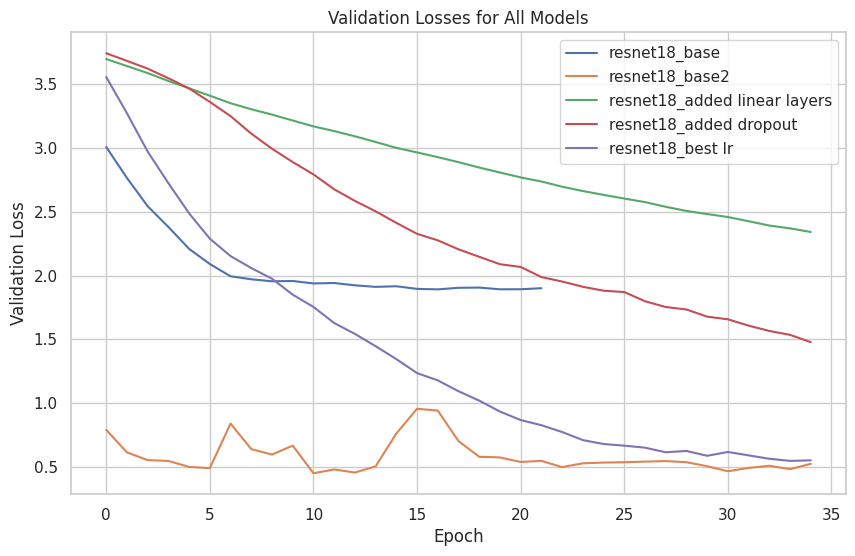

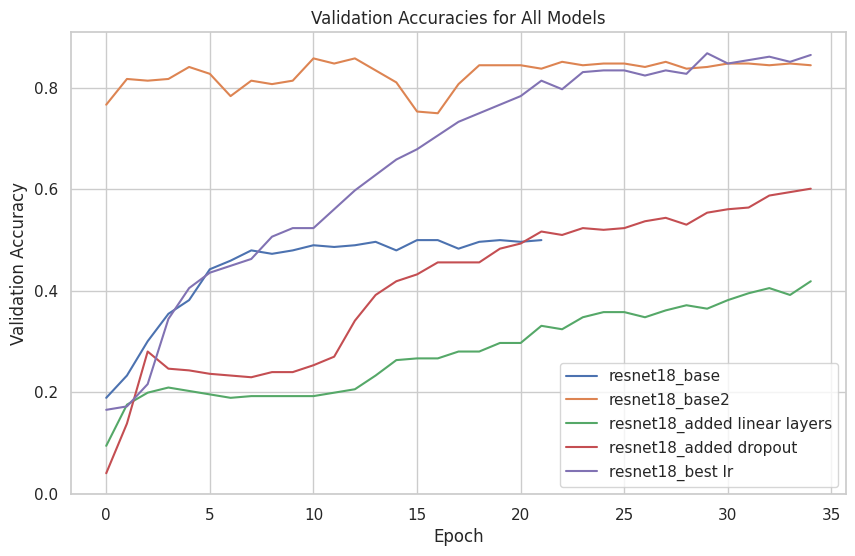

In [ ]:
# Plot val_losses for all models
plt.figure(figsize=(10, 6))
for index, row in df_metrics.iterrows():
    plt.plot(row['val_losses'], label=row['model_name'])

plt.title('Validation Losses for All Models')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

# Plot val_accuracies for all models
plt.figure(figsize=(10, 6))
for index, row in df_metrics.iterrows():
    plt.plot(row['val_accuracies'], label=row['model_name'])

plt.title('Validation Accuracies for All Models')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()